# Simulated Data

The data generating process induce the below causal graph



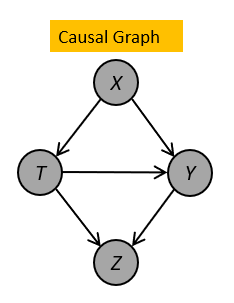

In [1]:

"""
Estimating the causal effect of sodium on blood pressure in a simulated example
adapted from Luque-Fernandez et al. (2018):
    https://academic.oup.com/ije/article/48/2/640/5248195
"""

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression


def generate_data(n=1000, seed=0, beta1=1.05, alpha1=0.4, alpha2=0.3, binary_treatment=True, binary_cutoff=3.5):
    np.random.seed(seed)
    age = np.random.normal(65, 5, n)
    sodium = age / 18 + np.random.normal(size=n)
    if binary_treatment:
        if binary_cutoff is None:
            binary_cutoff = sodium.mean()
        sodium = (sodium > binary_cutoff).astype(int)
    blood_pressure = beta1 * sodium + 2 * age + np.random.normal(size=n)
    proteinuria = alpha1 * sodium + alpha2 * blood_pressure + np.random.normal(size=n)
    hypertension = (blood_pressure >= 140).astype(int)  # not used, but could be used for binary outcomes
    return pd.DataFrame({'blood_pressure': blood_pressure, 'sodium': sodium,
                         'age': age, 'proteinuria': proteinuria, 'hypertension': hypertension})



In [59]:
data = generate_data(beta1=1.05, alpha1=.4, alpha2=.3, binary_treatment=True, n=20_000)

## Predictive Analysis

Lets fit a linear regression (OLS) model to see what is the impact of sodium on blood pressure 

In [3]:
import statsmodels.formula.api as smf

### Effect of Sodium on blood_pressure

In [4]:
model = smf.ols(f"blood_pressure ~ sodium + age + proteinuria", data=data).fit()
model.params

Intercept     -0.030690
sodium         0.847424
age            1.835748
proteinuria    0.274511
dtype: float64

# Structured Causal Model: Causal Analysis

Given the causal graph, we should condition on age as confounder and not on proteinuria as collider. Otherwise, we will 

In [5]:
model = smf.ols(f"blood_pressure ~ sodium + age ", data=data).fit()
model.params

Intercept   -0.026509
sodium       1.059083
age          2.000245
dtype: float64

### Effect of Sodium on Proteinuria

In [6]:
# if we condition on blood_pressure (Y)
model = smf.ols(f"proteinuria ~ sodium + blood_pressure", data=data).fit()
model.params

Intercept         0.013951
sodium            0.453383
blood_pressure    0.299655
dtype: float64

In [7]:
# if we condition on age (X)
model = smf.ols(f"proteinuria ~ sodium + age ", data=data).fit()
model.params

Intercept    0.015232
sodium       0.771040
age          0.599239
dtype: float64

In [8]:
# if we condition on age (X)
model = smf.ols(f"proteinuria ~ C(sodium) + age + blood_pressure", data=data).fit()
model.params

Intercept         0.023355
C(sodium)[T.1]    0.446495
age              -0.013717
blood_pressure    0.306440
dtype: float64

### Effect of Sodium on Hypertension

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

glm = smf.glm("hypertension ~ sodium", data=data, family=sm.families.Binomial()).fit()
glm.params

Intercept   -2.233269
sodium       1.031368
dtype: float64

In [10]:

glm = smf.glm("hypertension ~ sodium + age ", data=data, family=sm.families.Binomial()).fit()
glm.params

Intercept   -270.558799
sodium         2.172016
age            3.865241
dtype: float64

In [11]:

glm = smf.glm("hypertension ~ sodium + age + proteinuria", data=data, family=sm.families.Binomial()).fit()
glm.params

Intercept     -281.251695
sodium           1.871042
age              3.737998
proteinuria      0.467118
dtype: float64

# Potential Outcome:

In [60]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

glm = (
    smf
    .glm("""sodium ~ age  """, # maybe drop proteinuria
        data=data, family=sm.families.Binomial())
    .fit()
)
data['propensity_score'] = glm.fittedvalues # glm.predict()

In [64]:
df_treat = data[data['sodium'] == 1].reset_index(drop=True)
df_ctrl = data[data['sodium'] == 0].reset_index(drop=True)

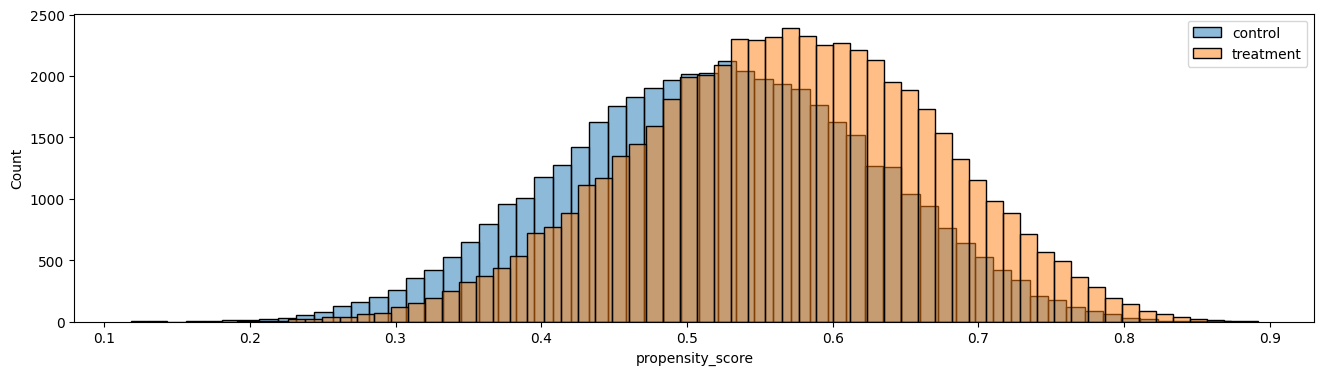

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(16, 4))

sns.histplot(df_ctrl['propensity_score'], alpha=.5, ax=ax, label='control', bins=60)
sns.histplot(df_treat['propensity_score'], alpha=.5, ax=ax, label='treatment', bins=60)
ax.legend();

In [42]:
len(df_ctrl), len(df_treat)

(4566, 5434)

## Potential Outcome: Propensity Score Matching

Matching is based on finding people in the two treatment groups that have similar propensity scores. This is done by taking a person from the smallest of the two groups (here the group for which DIET=1), and finding a person in the other group that is most like this person in terms of its propensity score

There is a trade-off in bias and precision between matching with replacement and without (1:1). Matching with replacement allows for reduced bias because of better matching between subjects. Matching without replacement has better precision because more subjects are used. [Further Reading](https://www.publichealth.columbia.edu/research/population-health-methods/propensity-score-analysis#:~:text=There%20is%20a%20trade%2Doff,because%20more%20subjects%20are%20used.)


Below is a quick solution proposed by [Causal Inference in Python](https://learning.oreilly.com/library/view/causal-inference-in/9781098140243/). [Chapter 5]

In [43]:
from  sklearn.neighbors import KNeighborsRegressor
X = 'propensity_score'
y = 'blood_pressure'

mt0 = KNeighborsRegressor(n_neighbors=1).fit(df_ctrl[[X]], df_ctrl[y])
mt1 = KNeighborsRegressor(n_neighbors=1).fit(df_treat[[X]], df_treat[y])

predicted = pd.concat([
    # find counterfactual for the treated looking at the untreated knn model
    df_treat.assign(blood_pressure_cf=mt0.predict(df_treat[[X]])),
    
    # find counterfactual for the untreated looking at the treated knn model
    df_ctrl.assign(blood_pressure_cf=mt1.predict(df_ctrl[[X]]))
])
predicted.head()

,blood_pressure,sodium,age,proteinuria,hypertension,propensity_score,blood_pressure_cf
0,149.020569,1,73.820262,45.477403,1,0.825698,135.961591
1,141.655496,1,69.893690,43.400773,1,0.802419,144.053390
2,153.887146,1,76.204466,46.701443,1,0.835238,145.339591
3,147.221633,1,74.337790,45.220249,1,0.769543,134.548672
4,141.358777,1,69.750442,41.944342,1,0.606723,156.089104


In [44]:
np.mean(
    (predicted["blood_pressure"] - predicted["blood_pressure_cf"]) * predicted['sodium']  
    + (predicted["blood_pressure_cf"] - predicted['blood_pressure']) * (1 - predicted['sodium'])
)

0.8112121570719136

We observe from above value that both linear regression in previous section and propensity matching drive almost similar treatment effect

In [45]:
def propensity_matching(df_small, df_large, replacement=True, size:int=None):
    """ 
    matching the propensities from the smaller df to the bigger df without replacement.

    """ 

    # the larger df will keep shrinking during matching     
    _df_large = df_large.copy(deep=True)
    size = size if size else len(df_small) 
    matched_dict = [] 
    for row in range(size):
        diff = _df_large['propensity_score'] - df_small.iloc[row]['propensity_score']
        ind = diff.abs().argmin()
        _dict = _df_large.iloc[ind].to_dict()
        matched_dict.append(_dict)
        if not replacement:
            _df_large = _df_large.drop(index=ind).reset_index(drop=True)
    
    print(f'#Unique samples: {len(matched_dict)} and left samples from large df {len(_df_large)}')
    return pd.DataFrame(matched_dict)

In [46]:
df_treat_matched = propensity_matching(df_ctrl, df_treat, replacement=True)

#Unique samples: 4566 and left samples from large df 5434


In [47]:
df_treat['blood_pressure'].mean(), df_treat_matched['blood_pressure'].mean(), df_ctrl['blood_pressure'].mean()

(132.74561733925634, 128.31069626800104, 127.56592530596747)

In [48]:
df_treat_matched['blood_pressure'].mean() - df_ctrl['blood_pressure'].mean()

0.7447709620335701

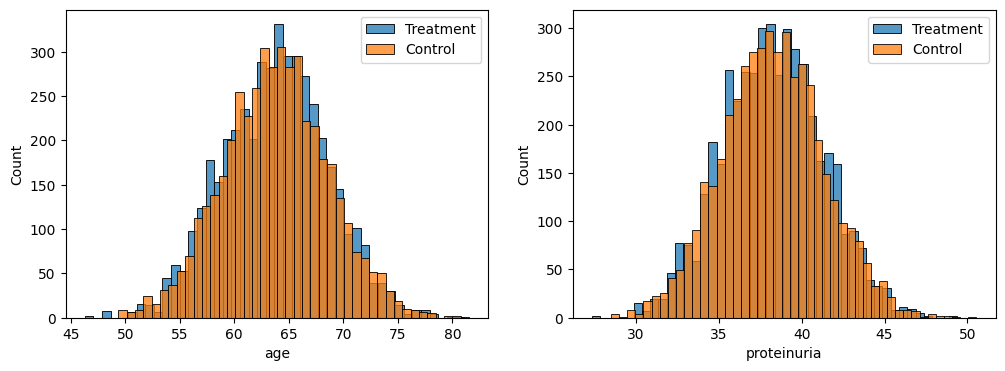

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df_treat_matched['age'], ax=ax[0], label='Treatment')
sns.histplot(df_ctrl['age'], ax=ax[0],  label='Control')

sns.histplot(df_treat_matched['proteinuria'], ax=ax[1], label='Treatment')
sns.histplot(df_ctrl['proteinuria'], ax=ax[1], label='Control')
ax[0].legend(), ax[1].legend();

## Potential Outcome: Inverse Propensity Score Weighting

We can also use inverse probability weighting (IPW) to account for unbalanced covariates. In this case, the estimated propensity scores $\pi_i$ are used to determine the probability that an individual would have received the treatment that they received: 

* for the treated ($T_i=1$) this is simply $\pi_i$
* for the control $T_i=0$ this is $1-\pi_i$


Next, we can use these probabilities as weights, by taking their inverse: That way, a case that received a treatment that she was very likely to receive, will get a small weight, while a case that received a treatment that she was very unlikely to receive, will get a large weight. Thus, the inverse probability weight indicates the number of persons from the population that this person represents. For the treated, this weight is $1/\pi_i$; for the untreated, it is $1/(1-\pi_i)$.

We can compute our estimate of the IPW-weighted ACE following the formulas given in the slides, or by using techniques which allow us to include weights directly. One such approach is available in the survey package. First, we create the weighted datafile (i.e., the pseudo population), and check the SMDs again.

In [65]:
y_treat = df_treat['blood_pressure'] * (1 / df_treat['propensity_score'])
y_ctrl = df_ctrl['blood_pressure'] * (1 / (1 - df_ctrl['propensity_score']))

print('y_treat', y_treat.mean())

print('y_ctrl', y_ctrl.mean())
ATE = (sum(y_treat) / len(data)) - (sum(y_ctrl) / len(data))

print(ATE)

y_treat 239.0993629899476
y_ctrl 287.5235289104315
1.0394847063820691


In [66]:
np.mean(
    data["blood_pressure"] * (data["sodium"] - data["propensity_score"]) 
        / 
    (data["propensity_score"]*(1 - data["propensity_score"]))
)

1.0394847063812376

In [31]:
# pd.DataFrame([y_treat, y_ctrl]).T
df_treat.shape

(5434, 6)

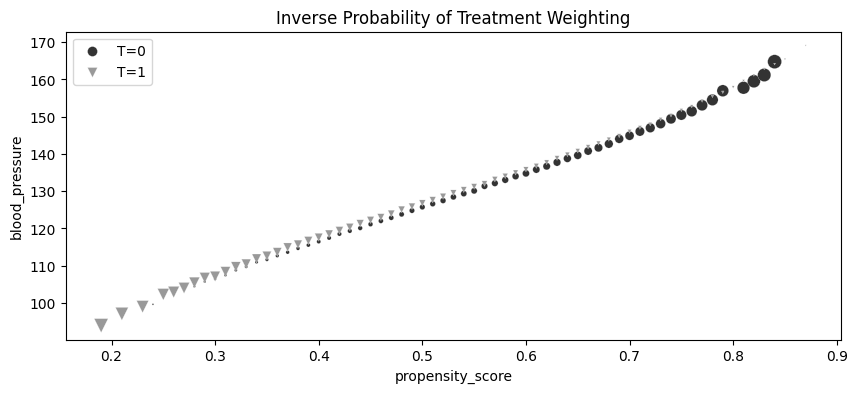

In [126]:
color=['0.2', '0.6', '1.0']
marker=['o', 'v', 'd', 'p']
g_data = (data
          .assign(
              weight = data["sodium"]/data["propensity_score"] + (1-data["sodium"])/(1-data["propensity_score"]),
              propensity_score=data["propensity_score"].round(2)
          )
          .groupby(["propensity_score", "sodium"])
          [["weight", "blood_pressure"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
for t in [0, 1]:
    sns.scatterplot(data=g_data.query(f"sodium=={t}"), y="blood_pressure", x="propensity_score", size="weight",
                    sizes=(1,100), color=color[t], legend=None, label=f"T={t}", marker=marker[t])

plt.title("Inverse Probability of Treatment Weighting")
plt.legend()